In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [83]:
# links = pd.read_csv('ml-latest-small/links.csv')
# movies = pd.read_csv('ml-latest-small/movies.csv')
# ratings = pd.read_csv('ml-latest-small/ratings.csv')
# tags = pd.read_csv('ml-latest-small/tags.csv')

In [84]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [85]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [86]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [87]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [88]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Рассмотрим сколько в среднем тегов проставляет пользователь фильмам. Большинство пользователей проставляет очень мало тегов, но есть люди, которые проставили более, чем 1400 тегов.

array([[<Axes: title={'center': 'tag'}>]], dtype=object)

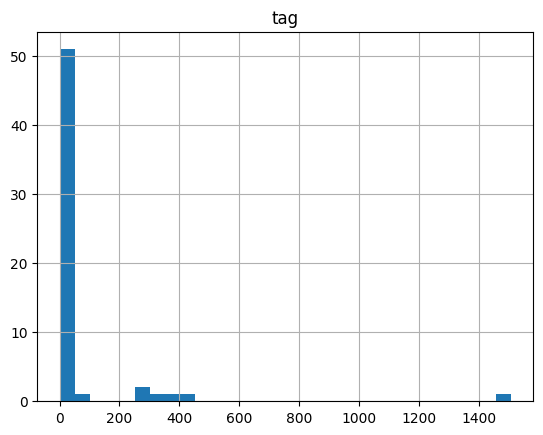

In [89]:
tags.groupby('userId')[['tag']].count().hist(bins=30)

In [90]:
tags.groupby('userId').tag.count().median()

4.0

Медиана = 4, получается, что половина пользователей проставляет больше 4 тегов, а половина меньше

In [91]:
tags.groupby('userId').tag.count().mean()

63.5

Среднее значение = 63.5, получается, что в среднем человек пишет по 63.5 тега. Но на самом деле это не так, такое значение получается из-за слишком активных пользователей (как видно на графике выше), которые проставили очень много тегов (более 1400)

In [92]:
print("ratings columns:", ratings.columns)
print("tags columns:", tags.columns)
print("movies columns:", movies.columns)
print("links columns:", links.columns)

ratings columns: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
tags columns: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies columns: Index(['movieId', 'title', 'genres'], dtype='object')
links columns: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [93]:
nUsers = ratings.userId.unique().shape[0]
nItems = ratings.movieId.unique().shape[0]

print ("Users \tN={}\tMax={}".format(nUsers, max(ratings.userId)))
print ("Movies \tN={}\tMax={}".format(nItems, max(ratings.movieId)))

Users 	N=610	Max=610
Movies 	N=9724	Max=193609


In [94]:
ratingsMovie=pd.merge(ratings, movies, on='movieId', how='left')
ratingsMovie.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [95]:
# Объединение таблиц
movie_data = pd.merge(ratings, movies, on='movieId')
movie_data = pd.merge(movie_data, tags, on=['userId', 'movieId'], how='left')

In [96]:
# Создание признаков TF-IDF для тегов
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tags_tfidf = tfidf_vectorizer.fit_transform(movie_data['tag'].fillna(''))
tags_tfidf_df = pd.DataFrame(tags_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [97]:
# Создание признаков TF-IDF для жанров
genres_tfidf = tfidf_vectorizer.fit_transform(movie_data['genres'])
genres_tfidf_df = pd.DataFrame(genres_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [98]:
# Средние оценки пользователя и фильма
user_mean_ratings = movie_data.groupby('userId')['rating'].mean()
movie_mean_ratings = movie_data.groupby('movieId')['rating'].mean()

In [99]:
user_mean_ratings.head()

userId
1    4.366379
2    4.128571
3    2.435897
4    3.555556
5    3.636364
Name: rating, dtype: float64

In [100]:
movie_mean_ratings.head()

movieId
1    3.920930
2    3.441964
3    3.245283
4    2.357143
5    3.040000
Name: rating, dtype: float64

In [101]:
# Объединение всех признаков
features = pd.concat([tags_tfidf_df, genres_tfidf_df, user_mean_ratings[movie_data['userId']].reset_index(drop=True),
                      movie_mean_ratings[movie_data['movieId']].reset_index(drop=True)], axis=1)

In [102]:
features.shape

(102677, 1667)

In [103]:
features.head()

,06,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001,250,...,musical,mystery,noir,romance,sci,thriller,war,western,rating,rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.366379,3.92093
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.636364,3.92093
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.230263,3.92093
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.448148,3.92093
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.209524,3.92093


In [104]:
y = movie_data['rating']

In [105]:
y.head()

0    4.0
1    4.0
2    4.5
3    2.5
4    4.5
Name: rating, dtype: float64

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [107]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [108]:
predictions_ln = model.predict(X_test)

С rmse все плохо, в будущем будем ограничивать значения от 0 до 5 (тк рейтинг может быть только в этих пределах)

In [109]:
rmse_ln = np.sqrt(mean_squared_error(y_test, predictions_ln))
print(f'Root Mean Squared Error (RMSE): {rmse_ln}')

Root Mean Squared Error (RMSE): 655720673.1444823


Так как интерпретировать rmse довольно сложно, то ниже приведем более понятную интерпритацию, далее будем смотреть только на rmse, но уже такие значения довольно неплохи (смотреть репорт).

Попробуем вместо использования RMSE сделать оценку модели для задачи регрессии с помощью Classification Report. Поскольку это задача регрессии, то вместо этого мы можем рассмотреть как задачу классификации, например, бинарную классификацию, где будем предсказывать, например, выше или ниже средней оценки (мы предсказали собственно)

In [110]:
from sklearn.metrics import classification_report

# Порог для бинарной классификации (выше или ниже средней оценки)
threshold = y.mean()

# Преобразование реальных оценок в бинарные метки
y_test_binary = (y_test > threshold).astype(int)
predictions_binary = (predictions_ln > threshold).astype(int)

# Classification Report
classification_rep = classification_report(y_test_binary, predictions_binary)
print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72     10644
           1       0.69      0.77      0.73      9892

    accuracy                           0.72     20536
   macro avg       0.73      0.73      0.72     20536
weighted avg       0.73      0.72      0.72     20536


In [111]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_ln})
results_df.head()

,Actual,Predicted
75496,4.0,3.977245
76461,4.0,3.251672
97453,2.5,3.184650
61763,3.0,2.704847
60537,2.5,3.018909


In [126]:
import seaborn as sns
def lets_predict(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = np.clip(predictions, 0, 5)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Actual', y='Predicted', data=results, marker='o', linestyle='-', alpha=0.7)
    plt.title(f'Actual vs Predicted Values\nModel: {model.__class__.__name__} | RMSE: {rmse:.4f}')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.show()
    return predictions, rmse, results

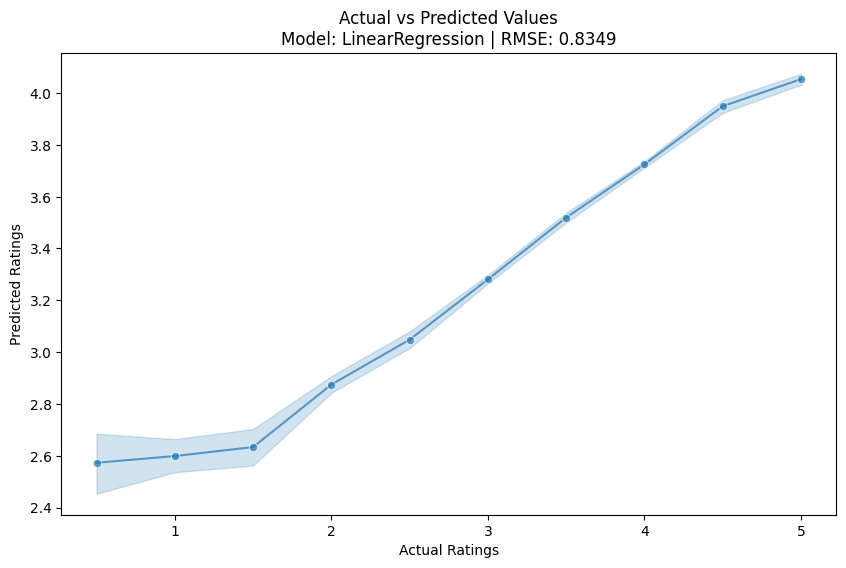

In [113]:
model = LinearRegression()
pr_ln, rmse_ln, results_ln = lets_predict(model)

In [114]:
 rmse_ln

0.8348861254983501

In [115]:
results_ln.head()

,Actual,Predicted
75496,4.0,3.977245
76461,4.0,3.251672
97453,2.5,3.184650
61763,3.0,2.704847
60537,2.5,3.018909


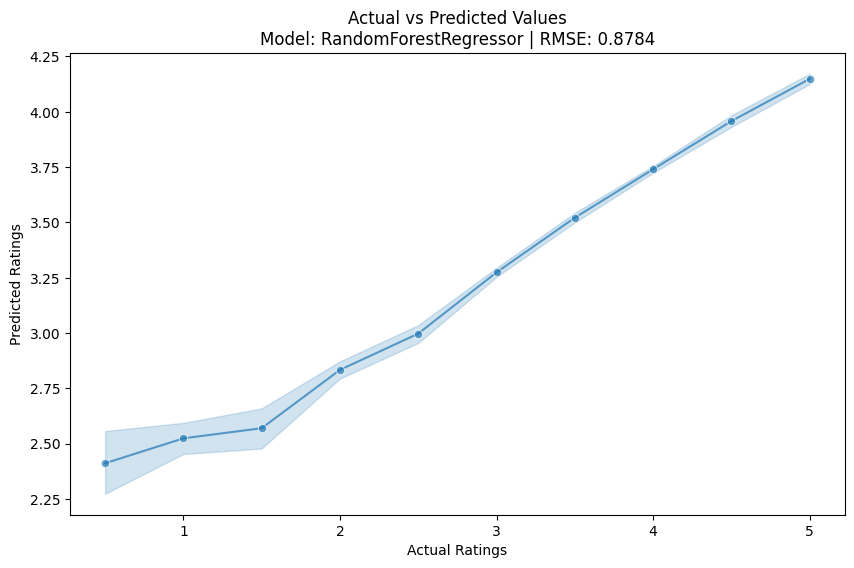

In [116]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, random_state=42)
pr_rf, rmse_rf, results_rf = lets_predict(model)

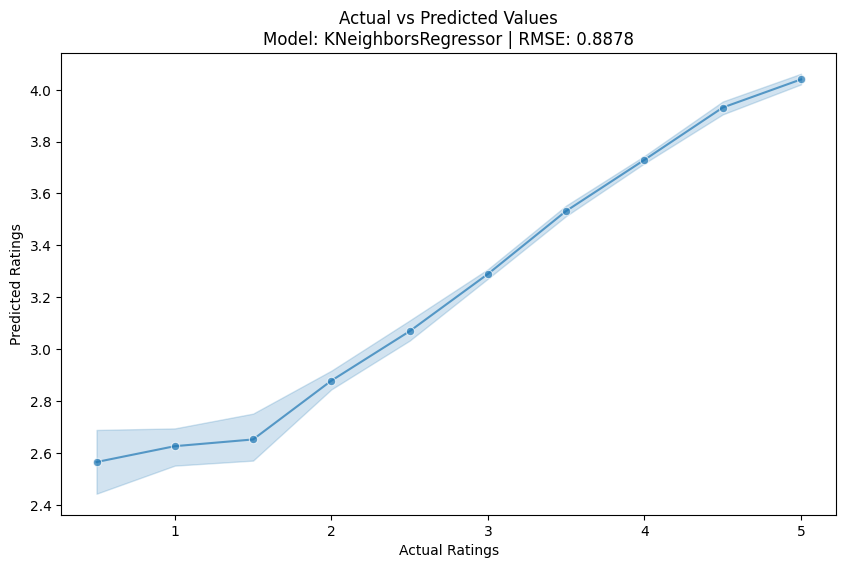

In [117]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor()
pr_knn, rmse_knn, results_knn = lets_predict(knn_model)

Боже, оно вечность считается.... даже на T4...

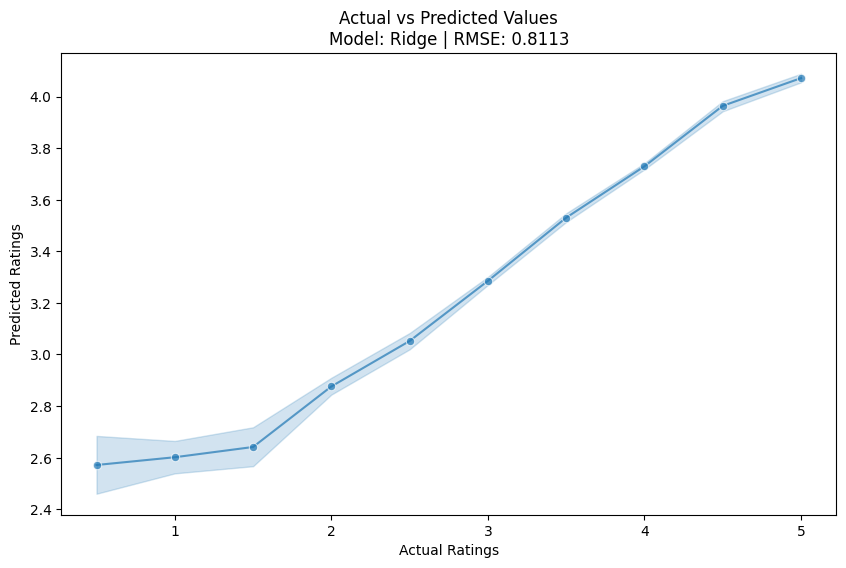

In [127]:
from sklearn.linear_model import Ridge
ridge_model = Ridge()
pr_ridge, rmse_ridge, results_ridge = lets_predict(ridge_model)

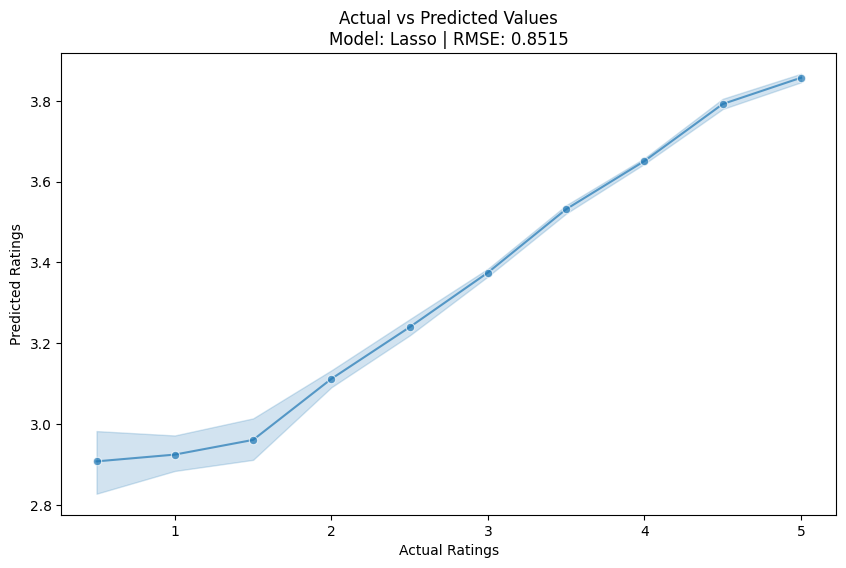

In [119]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.1)
pr_lasso, rmse_lasso, results_lasso = lets_predict(lasso_model)

Рассмотрим насколько ошибаются модели на первых 10 значениях тестовой выборки.

In [120]:
import pandas as pd

model_names = ['LinearRegression', 'RandomForestRegressor', 'KNeighborsRegressor', 'Ridge', 'Lasso']
real = y_test[0:10]


predictions_data = {
    'LinearRegression': pr_ln[0:10],
    'RandomForestRegressor': pr_rf[0:10],
    'KNeighborsRegressor': pr_knn[0:10],
    'Ridge': pr_ridge[0:10],
    'Lasso': pr_lasso[0:10]
}

rmse_data = {
    'LinearRegression': rmse_ln,
    'RandomForestRegressor': rmse_rf,
    'KNeighborsRegressor': rmse_knn,
    'Ridge': rmse_ridge,
    'Lasso': rmse_lasso,
    'Actual Ratings': 0
}


predictions_df = pd.DataFrame(predictions_data)
predictions_df.insert(0, 'Actual Ratings', real.values)
rmse_df = pd.DataFrame(rmse_data, index=['RMSE'])
results_df = pd.concat([predictions_df, rmse_df])
results_df.T

,0,1,2,3,4,5,6,7,8,9,RMSE
Actual Ratings,4.000000,4.000000,2.500000,3.000000,2.500000,0.500000,4.000000,3.000000,4.000000,3.000000,0.000000
LinearRegression,3.977245,3.251672,3.184650,2.704847,3.018909,1.042168,4.189824,2.967925,3.588403,3.385972,0.834886
RandomForestRegressor,4.250000,2.450000,2.900000,2.850000,3.150000,0.500000,4.500000,3.950000,4.800000,3.200000,0.878358
KNeighborsRegressor,3.900000,3.000000,3.500000,3.200000,2.900000,0.700000,4.200000,3.700000,4.000000,3.400000,0.887845
Ridge,3.979732,3.253615,3.184960,2.711379,3.021916,1.028562,4.193072,2.965737,3.594187,3.386894,0.811300
Lasso,3.889726,3.363251,3.416328,3.152752,3.230832,1.649884,3.906795,3.092688,3.602849,3.384742,0.851481


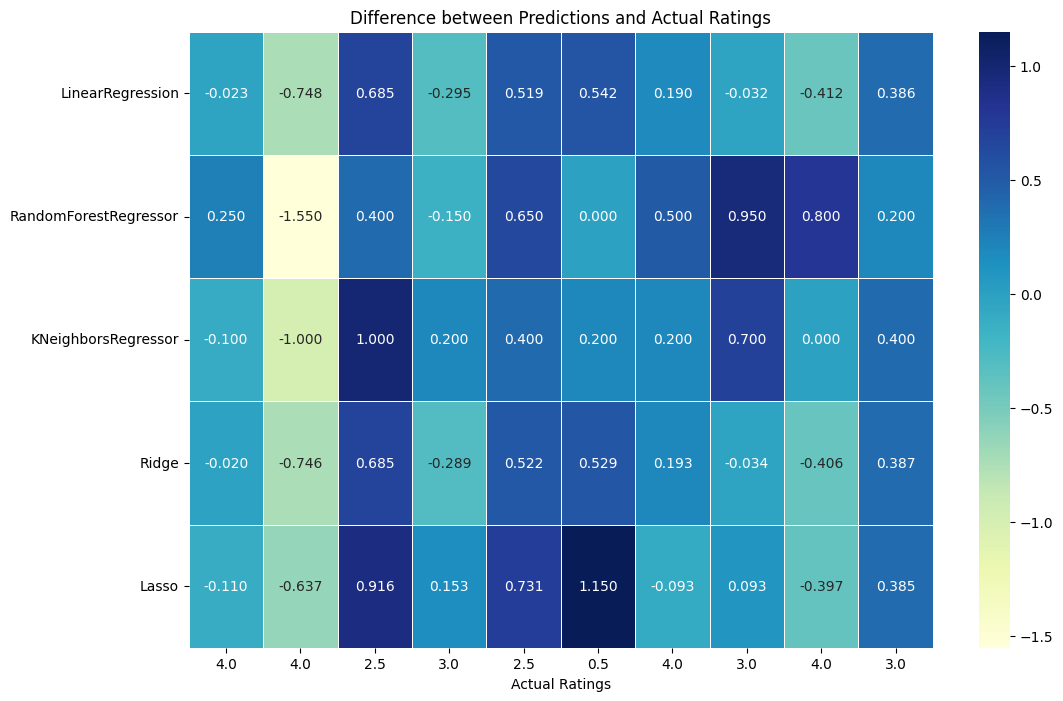

In [121]:
diff_df = predictions_df.copy()
diff_df[model_names] = predictions_df[model_names].sub(predictions_df['Actual Ratings'], axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(diff_df.set_index('Actual Ratings')[model_names].T, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title('Difference between Predictions and Actual Ratings')
plt.show()

Таким образом, основываясь на графики, можно сказать, что модели часто делают похожие ошибки. Так как мы используем Clip, то есть наши значения не могут быть за пределами [0,5], то большинство ошибок концентрируется вокруг 0 и 5 соответственно. На самом деле, только у линейной регрессии были замечены сильные отклонения из-за неиспользования clip, остальные модели более-менее стабильны.
KNN обучается очень долго. LinearRegression и RandomForest быстрее, но все же приходится ждать, еще многое от параметров зависит.  
С базовыми параметрами, конечно, выигрывает Ridge и Lasso. Очень быстрое обучение и хорошая метрика по итогу. Но Ridge все же получше.